### Imports

In [95]:
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.preprocessing import StandardScaler

### Reading Data

In [96]:
data = pd.read_csv("C:/Users/Fernando/Box/AI Coding Camp 2/Datasets/US01/HR.csv")

### Exploring Data

In [97]:
data.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


### Extracting Labels

In [98]:
labels = data['left']
data = data.drop('left', axis=1)
labels.head()

0    1
1    1
2    1
3    1
4    1
Name: left, dtype: int64

### Renaming Unproperly Named Column

In [99]:
data = data.rename(columns={'sales': 'department'})

### Splitting Data Into Train and Test Set

In [100]:
X = data
y = labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Training set size:", X_train.shape[0])
print("Test set size:", X_test.shape[0])

Training set size: 11999
Test set size: 3000


### One-hot-encoding Categorical Columns and Normalizing Data

In [101]:
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)
feature_names = X_train.columns.tolist()

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

### Converting Data into Tensors

In [102]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

### Training the XGBoost Model

In [103]:
train_dmatrix = xgb.DMatrix(X_train_tensor, label=y_train_tensor, feature_names=feature_names)
test_dmatrix = xgb.DMatrix(X_test_tensor, label=y_test_tensor, feature_names=feature_names)

params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'eta': 0.1,
    'max_depth': 6
}

num_rounds = 100

xgb_model = xgb.train(params, train_dmatrix, num_rounds)


### Geting Predictions

In [104]:
preds = xgb_model.predict(test_dmatrix)

print(preds)


[0.01320871 0.00069411 0.00340859 ... 0.03053484 0.02156573 0.01510257]


### Finding the Treshold That Maximizes The f1 Score

In [105]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, log_loss

threshold = 0
f1_scores = []
while threshold < 1:
    threshold += 0.01
    binary_preds = [1 if p >= threshold else 0 for p in preds]
    f1 = f1_score(y_test, binary_preds)
    f1_scores.append((threshold,f1))

best_treshold = max(f1_scores, key=lambda x: x[1])[0]
best_treshold

0.49000000000000027

### Different Metrics to Measure Model Performance

In [114]:
binary_preds = [1 if p >= best_treshold else 0 for p in preds]

accuracy = accuracy_score(y_test, binary_preds)
precision = precision_score(y_test, binary_preds)
recall = recall_score(y_test, binary_preds)
f1 = f1_score(y_test, binary_preds)
conf_matrix = confusion_matrix(y_test, binary_preds)
logloss = log_loss(y_test, preds)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Confusion Matrix: \n{conf_matrix}")
print(f"Log Loss: {logloss:.4f}")

print()

print("Precision of stayed (0): ", conf_matrix[0][0]/(conf_matrix[0][0]+conf_matrix[0][1]))
print("Precision of left (1): ", conf_matrix[1][1]/(conf_matrix[1][1]+conf_matrix[1][0]))

print("Recall of stayed (0): ", conf_matrix[0][0]/(conf_matrix[0][0]+conf_matrix[1][0]))
print("Recall of left (1): ", conf_matrix[1][1]/(conf_matrix[1][1]+conf_matrix[0][1]))

recal_left = conf_matrix[1][1]/(conf_matrix[1][1]+conf_matrix[0][1])
precision_left = conf_matrix[1][1]/(conf_matrix[1][1]+conf_matrix[1][0])

print("F1 Score of stayed (0): ", 2*conf_matrix[0][0]/(2*conf_matrix[0][0]+conf_matrix[0][1]+conf_matrix[1][0]))
print("F1 Score of left (1): ", 2*recal_left*precision_left/(recal_left+precision_left))

Accuracy: 0.9297
Precision: 0.9598
Recall: 0.7353
F1 Score: 0.8327
Confusion Matrix: 
[[2264   22]
 [ 189  525]]
Log Loss: 0.2304

Precision of stayed (0):  0.9903762029746281
Precision of left (1):  0.7352941176470589
Recall of stayed (0):  0.9229514879739095
Recall of left (1):  0.9597806215722121
F1 Score of stayed (0):  0.9554758387845537
F1 Score of left (1):  0.8326724821570182


### Precision and Recall Curve

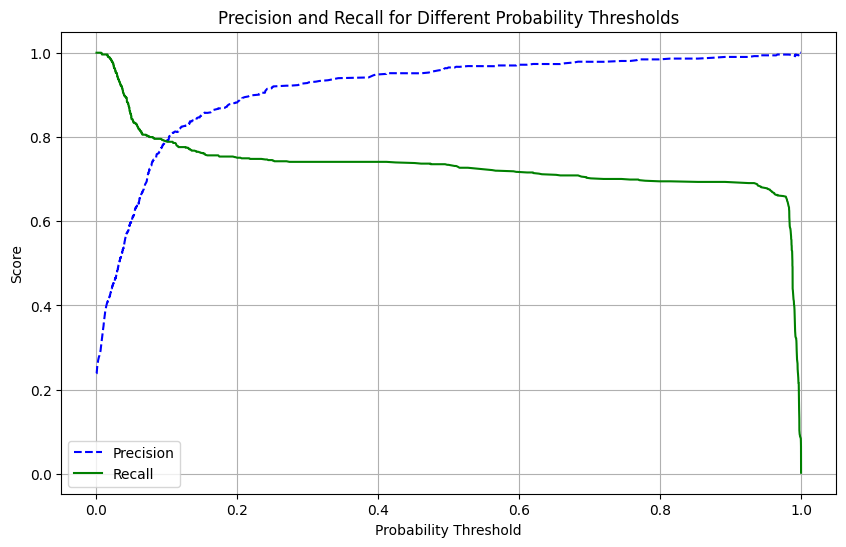

In [107]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

precision_curve, recall_curve, thresholds = precision_recall_curve(y_test, preds)

plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision_curve[:-1], 'b--', label='Precision')
plt.plot(thresholds, recall_curve[:-1], 'g-', label='Recall')
plt.xlabel('Probability Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall for Different Probability Thresholds')
plt.legend()
plt.grid(True)
plt.show()

### Probability Distribution by Class

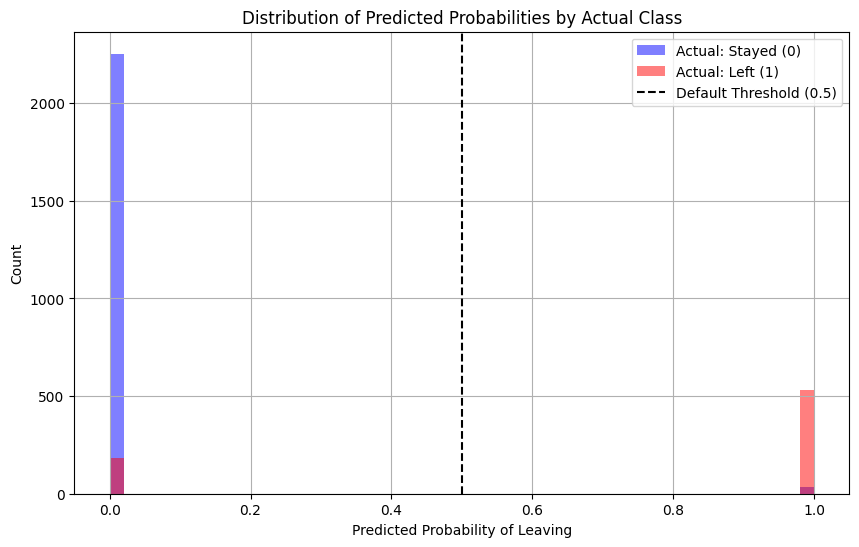

In [108]:
plt.figure(figsize=(10, 6))

prob_class_0 = [binary_preds[i] for i in range(len(y_test)) if y_test.iloc[i] == 0]
prob_class_1 = [binary_preds[i] for i in range(len(y_test)) if y_test.iloc[i] == 1]

plt.hist(prob_class_0, bins=50, alpha=0.5, label='Actual: Stayed (0)', color='blue')
plt.hist(prob_class_1, bins=50, alpha=0.5, label='Actual: Left (1)', color='red')
plt.axvline(x=0.5, color='black', linestyle='--', label='Default Threshold (0.5)')
plt.xlabel('Predicted Probability of Leaving')
plt.ylabel('Count')
plt.title('Distribution of Predicted Probabilities by Actual Class')
plt.legend()
plt.grid(True)
plt.show()

### Class Distribution Analysis

Class distribution in training data:
left
0    9142
1    2857
Name: count, dtype: int64
Percentage of employees who left: 23.81%


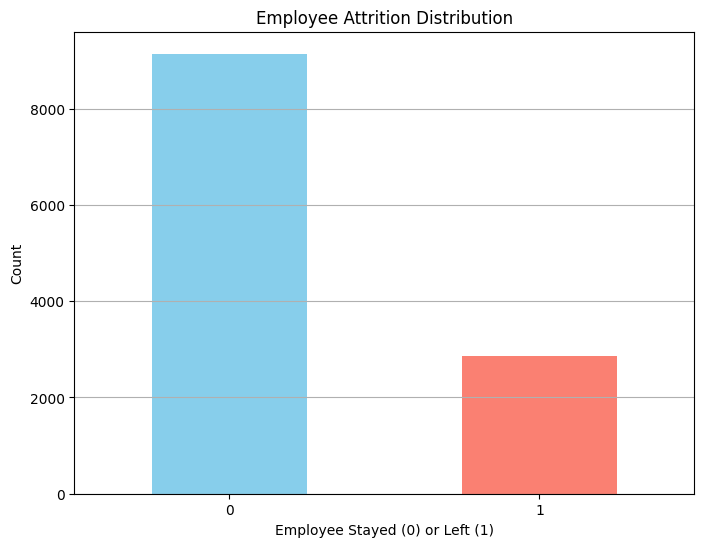

In [109]:
class_distribution = y_train.value_counts()
print("Class distribution in training data:")
print(class_distribution)
print(f"Percentage of employees who left: {class_distribution[1]/len(y_train)*100:.2f}%")

plt.figure(figsize=(8, 6))
class_distribution.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Employee Attrition Distribution')
plt.xlabel('Employee Stayed (0) or Left (1)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()



### Feature Importance Analysis

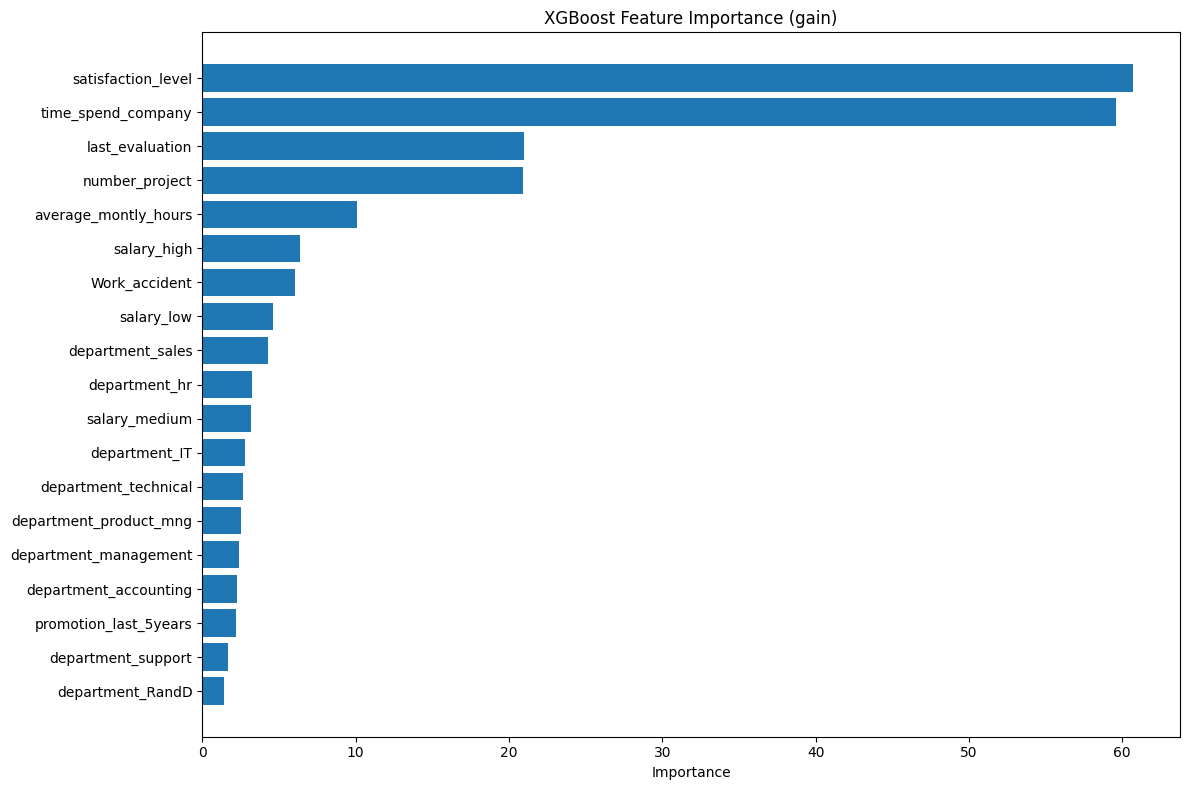


Feature Importance (weight):
                 Feature  Importance (weight)
0     satisfaction_level                480.0
3   average_montly_hours                472.0
1        last_evaluation                332.0
2         number_project                267.0
4     time_spend_company                256.0
15  department_technical                 44.0
17            salary_low                 41.0
5          Work_accident                 29.0
14    department_support                 25.0
10         department_hr                 24.0

Feature Importance (cover):
                   Feature  Importance (cover)
4       time_spend_company          242.559143
12  department_product_mng          240.145966
5            Work_accident          223.728607
2           number_project          215.314804
16             salary_high          197.463074
0       satisfaction_level          191.292984
6    promotion_last_5years          181.605164
7            department_IT          169.590408
3     averag

In [113]:

importance = xgb_model.get_score(importance_type='gain')
importance_df = pd.DataFrame(list(importance.items()), columns=['Feature', 'Importance'])
importance_df = importance_df.sort_values('Importance', ascending=False)


plt.figure(figsize=(12, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.title('XGBoost Feature Importance (gain)')
plt.gca().invert_yaxis()  
plt.tight_layout()
plt.show()

for imp_type in ['weight', 'cover', 'total_gain', 'total_cover']:
    try:
        importance = xgb_model.get_score(importance_type=imp_type)
        importance_df = pd.DataFrame(list(importance.items()), columns=['Feature', f'Importance ({imp_type})'])
        importance_df = importance_df.sort_values(f'Importance ({imp_type})', ascending=False)
        print(f"\nFeature Importance ({imp_type}):")
        print(importance_df.head(10))  
    except:
        print(f"Importance type '{imp_type}' not available")